In [1]:
#Needs to be run only once

#import Pkg
#Pkg.add("PyPlot")
#Pkg.add("FastGaussQuadrature")
#Pkg.add("https://github.com/pjabardo/Jacobi.jl")

# Eady Problem

First define some functions and constants associated with the Eady background state.

In [2]:
function u_linear(value)
    return value 
end

function dz(value::Float64) # du/dz for u_bar
    return 1
end 

function dq(value::Float64)
    return 0
end

function S_constant(value::Float64)
    return 1.
end

first_coefficient = 0.5 # barotropic coefficient for u_bar
u_zero = 0 # u_bar at z=0
beta = 0.0
;

Now define some functions associated with the exact solution to the Eady problem.

In [3]:
function cEady(kxValue::Float64)
    inner = (kxValue/2-coth(kxValue/2))*(kxValue/2-tanh(kxValue/2))
    c_value = 1/2 + 1/kxValue*((Complex(inner))^(1/2))
    return c_value
end

function AB(kxValue::Float64)
    c_value = cEady(kxValue)
    matrix = [ 1 kxValue*c_value; (c_value-1)*kxValue*sinh(kxValue)+1*cosh(kxValue) (c_value-1)*kxValue*cosh(kxValue)+1*sinh(kxValue)]
    solutions = nullspace(matrix)
    return solutions
end

function waveFunction(kxValue::Float64, zHeight)
    ABVal = AB(kxValue)
    waveReturn = ABVal[1]*cosh(kxValue*zHeight)+ABVal[2]*sinh(kxValue*zHeight)
    return waveReturn
end
;

Now generate a figure comparing the exact solution of the Eady problem to the new energy-conserving Galerkin approximation. The first block defines some auxiliary functions, then the second block uses them to generate the figure. Note that the output of the second block only shows one panel of the figure; all four panels are saved in the local directory as .eps files.

In [4]:
using PyPlot
include("GalerkinLinearStability.jl")
function createFourStabilityPlotsCompareToExact(sizeOfMatrix, S_function, growthRates, eigenvectors, waveSpeeds, kx_values, ky_value)
    B = B_ij(sizeOfMatrix)
    L = L_ij(sizeOfMatrix, S_function)
    M = M_ij(sizeOfMatrix)
    
    maxIndex = argmax(growthRates)
    maxKx = kx_values[maxIndex]
    highVector = eigenvectors[maxIndex]
    vectorSize = length(highVector)
    highVector_bottom = highVector[vectorSize] 
    psi_coeffs = highVector[1]*psi(sizeOfMatrix, maxKx, ky_value, M, L, 1.)-highVector_bottom*psi(sizeOfMatrix,maxKx,ky_value, M,L,0.)
    psi_coeffs = psi_coeffs - ( (maxKx^2 + ky_value^2)*M + L ) \ B*highVector[2:end-1]
    
    heights = collect(LinRange(0,1,100))
    psi_angles = zeros(length(heights))
    psi_amps = zeros(length(heights))
    psi_angles_exact = zeros(length(heights))
    psi_amps_exact = zeros(length(heights))
    psi_angles_cheb = zeros(length(heights))
    psi_amps_cheb = zeros(length(heights))
    for i=1:length(heights)
        psi_val = galerkin_p_psi_print(sizeOfMatrix, psi_coeffs, heights[i])
        psi_angles[i] = angle(psi_val)
        psi_amps[i] = abs(psi_val)
        
        psiValueExact = waveFunction(1.61, heights[i])
        psi_angles_exact[i]= angle(psiValueExact)
        psi_amps_exact[i] = abs(psiValueExact)
        
    end

    #Exact Growth Rates and wave speeds
    growthRates_exact = zeros(length(kx_values))
    w_speeds_exact = zeros(length(kx_values))
    for i =1:length(kx_values)
        c_value = cEady(kx_values[i])
        growthRates_exact[i] = kx_values[i]*imag(c_value)
        w_speeds_exact[i] = real(c_value)
    end
    
    plot(psi_amps/maximum(psi_amps), heights, label="Galerkin")
    plot(psi_amps_exact/maximum(psi_amps_exact), heights, label="Exact")
    legend(loc="center right")
    xlabel("Amplitude")
    ylabel("Height")
    savefig("EadyAmplitude.eps", format="eps", dpi=1000)
    cla()
    
    plot(kx_values, growthRates, label="Galerkin")
    plot(kx_values, growthRates_exact, label="Exact")
    legend(loc="upper right")
    xlabel("Zonal Wavenumber")
    ylabel("Growth Rate")
    savefig("EadyGrowthRates.eps", format="eps", dpi=1000)
    cla()
    
    plot(kx_values, waveSpeeds, label="Galerkin")
    plot(kx_values, w_speeds_exact, label="Exact")
    ylim(0,1)
    legend(loc="lower right")
    xlabel("Zonal Wavenumber")
    ylabel("Wave Speeds")
    savefig("EadyWaveSpeeds.eps", format="eps", dpi=1000) 
    cla()
    
    plot(psi_angles .- psi_angles[1], heights, label="Galerkin")
    plot(psi_angles_exact .- psi_angles_exact[1], heights, label="Exact")
    legend(loc="upper left")
    xlabel("Phase")
    ylabel("Height")
    savefig("EadyPhase.eps", format="eps", dpi=1000)
    
end
;



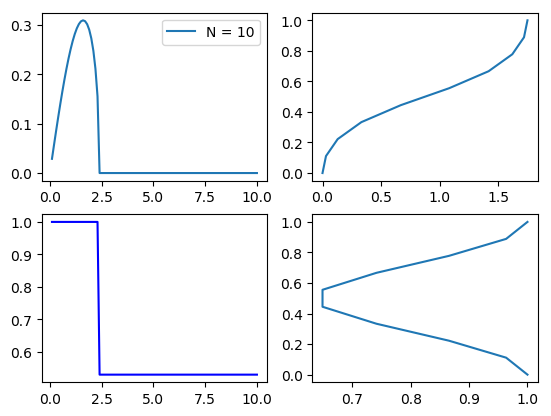

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x000000001A9184E0>

In [5]:
include("ChebyshevLinearStability.jl")
include("GalerkinLinearStability.jl")

matrixSize = 10
nodePoints = matrixSize + 2
# In the Eady problem, using nodePoints=matrixSize+2 is sufficient to
# guarantee machine-precision accuracy in the quadrature

kxStart = 0.1
kxFinish = 10.
steps = 100

ky = 0
kxs_eady_four = collect(LinRange(kxStart, kxFinish, steps)) 
#eigenValuesAndVectors_eady_four = getCompleteStabilityEigenObjectsOfKx(matrixSize, beta, ky, kxs_eady_four, S_constant, dq, dz, dy_vartheta_bar(S_constant, dz, 1.), dy_vartheta_bar(S_constant, dz, 0.), first_coefficient)
#growthRates_eady_four, vectors_eady_four, w_speeds_eady_four = getStabilityValues(eigenValuesAndVectors_eady_four, kxs_eady_four)


### Test running the Chebyshev Colinear
growthRates_c, eigenvectors_c, waveSpeeds_c = growthRateEigenValues_Cheb(matrixSize, beta, ky, kxs_eady_four, S_constant, dq, dy_vartheta_bar(S_constant, dz, 1.), dy_vartheta_bar(S_constant, dz, 0.), first_coefficient)
createFourStabilityPlots_Cheb(matrixSize, S_constant, growthRates_c, eigenvectors_c, waveSpeeds_c, kxs_eady_four, ky)

#The line below will generate comparison images of Galerkin to Exact
#createFourStabilityPlotsCompareToExact(matrixSize, S_constant, growthRates_eady_four, vectors_eady_four, w_speeds_eady_four, kxs_eady_four, ky)

Next compare the convergence of the growth rate at kx=1.61, ky=0 (approximately the fastest-growing mode) for the Galerkin, second-order energy-conserving finite-difference, and non-energy-conserving Chebyshev collocation methods.

In [6]:
include("FDLinearStability.jl")
include("ChebyshevLinearStability.jl")
include("GalerkinLinearStability.jl")

max_kxs = 1.61
ky = 0.0
sN = 2 .^(3:6)

growthRates_G = zeros(length(sN))
growthRates_F = zeros(length(sN))
growthRates_C = zeros(length(sN))

for ii=1:length(sN)
    matrixSize = sN[ii]
    nodePoints = matrixSize + 2
    eigenValuesAndVectors_G = getCompleteStabilityEigenObjectsOfKx(matrixSize, beta, ky, max_kxs, S_constant, dq, dz, 1.0, 1.0, first_coefficient)
    growthRates, eVecs, waveSpeeds = getStabilityValues(eigenValuesAndVectors_G, max_kxs)
    growthRates_G[ii] = maximum(growthRates)

    growthRates, eVecs, waveSpeeds = growthRateEigenValues_fd(matrixSize, beta, ky, max_kxs, S_constant, u_linear)
    growthRates_F[ii] = maximum(growthRates)

    growthRates, eVecs, waveSpeeds = growthRateEigenValues_Cheb(matrixSize, beta, ky, max_kxs, S_constant, dq, 1.0, 1.0, u_zero)
    growthRates_C[ii] = maximum(growthRates)
    
    println("Done with ", sN[ii])
end

Done with 8
Done with 16
Done with 32
Done with 64


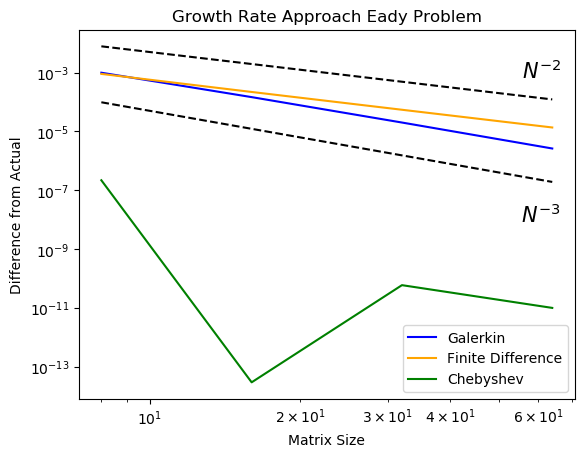

PyObject Text(-10, 10, '$N^{-3}$')

In [8]:
#Needs the above cell run first
bestValue_eady = 1.61*imag(cEady(1.61))

diffs_G = abs.(growthRates_G.-bestValue_eady)
diffs_F = abs.(growthRates_F.-bestValue_eady)
diffs_C = abs.(growthRates_C.-bestValue_eady)
plot(sN,diffs_G, label="Galerkin", color="b")
plot(sN,diffs_F, label="Finite Difference", color="orange")
plot(sN,diffs_C, label="Chebyshev",color="g")
plot(sN, .5*float(sN).^-2, color="k", linestyle="dashed")
plot(sN, .05*float(sN).^-3, color="k", linestyle="dashed")
title("Growth Rate Approach Eady Problem")
xlabel("Matrix Size")
ylabel("Difference from Actual")
yscale("log")
xscale("log")
legend(loc="lower right")
annotate(L"$N^{-2}$",
	xy=[1;0.82],
	xycoords="axes fraction",
	xytext=[-10,10],
	textcoords="offset points",
	fontsize=15.0,
	ha="right",
	va="bottom")
annotate(L"$N^{-3}$",
	xy=[1;0.43],
	xycoords="axes fraction",
	xytext=[-10,10],
	textcoords="offset points",
	fontsize=15.0,
	ha="right",
	va="bottom")